In [1]:
# !pip install astropy
# !pip install astro-datalab


In [2]:
# Imports
from astropy import units as u
from astropy.coordinates import SkyCoord

import pandas as pd
import heapq
import os
import csv

from lightcurve_classifier_for_tess import tess_lightcurve
from prob_source_is_transient import final_prob_list
from human_component import human_check
from external_photometry import _delve_objects

In [3]:
#Program configuration 
SAVED_CATALOGUE_FILENAME = "testing.csv"   #Name the csv file you save this data to
HUMAN_CHECKER_ON = True        #Do you want to verify it?
OBJECTS_ADDENDED = 1   #Addends the top (number) result(s) from to the catalogue

In [4]:
def identifier_creator(source, filename):

    data = pd.read_csv(filename, names=["time_MDJD", "counts", "event_flag"], skiprows=1).apply(pd.to_numeric, errors='coerce')
    event_data = data[data["event_flag"] != 0.0]
    MJD = event_data["time_MDJD"].iloc[0]

    source_ra, source_dec = source[2], source[3]

    coord = SkyCoord(ra=source_ra*u.degree, dec=source_dec*u.degree, frame='icrs')
    angle_source_ra = coord.ra.to_string(unit=u.hour, sep=':', precision=0, pad=True)[:5]
    angle_source_dec = coord.dec.to_string(unit=u.degree, sep=':', precision=0, alwayssign=True, pad=True)[:6]

    # Adjust MJD precision to 5 characters
    MJD = f"{MJD:.0f}"


    identifier = "TSS_J" + angle_source_ra + angle_source_dec +"T" + MJD 
    return identifier


In [5]:
def addend_transient_cat(cat, filename, indices):
    """
    (source_list, column_labels, final_probabilities, os.path.splitext(filename)[0], objects)
    Adds confirmed transient source(s) to the Classified Transients Catalogue CSV file.

    This function checks if the CSV file exists and if the source already exists in the file.
    If the file does not exist, it creates the file and writes the column labels.
    If the source does not exist in the file, it appends the source to the file.

    Parameters:
    source (list): A list containing the transient source data.
    column_labels (list): A list containing the column labels for the CSV file.

    Returns:
    None

    PROBLEM:
    The first time we run this with all three test cases (provided the file Classified_Transients_Catalogue.csv does not exist)
    it will not add the first source to the file. (it seems to be covered by the column labels)?
    """
    try:
        column_labels = list(cat.columns)  # Convert the Index object to a list
        column_labels.insert(0, "filename")  # Insert "TESS ID" at the front
        column_labels.insert(1, "identifier") # Insert "identifier" at the front
        tess_id = os.path.splitext(os.path.basename(filename))[0]
        file_path = SAVED_CATALOGUE_FILENAME 
        file_exists = os.path.isfile(file_path)

        source_list = [source.tolist() for index, source in cat.iterrows()]  # Extract a list of the soirce IDs


        for index in indices:
            source = source_list[index]

            source.insert(0, tess_id)

            identifier = identifier_creator(source, filename)
            source.insert(1, identifier)

            # Check if the catalogue already contains this transient
            if file_exists:
                with open(file_path, mode='r', newline='') as file:
                    existing_data = [tuple(row) for row in csv.reader(file)]

                if tuple(map(str, source)) in existing_data:
                    print(f"The transient source: {source[0]} already exists in the file.")
                    continue

            with open(file_path, mode='a', newline='') as file:
                writer = csv.writer(file)
                if not file_exists:
                    writer.writerow(column_labels)  # Write column labels if file doesn't exist
                    file_exists = True
                writer.writerow(source)
                print(f"The transient source: {source[0]} has been added to the file.")

    except Exception as e:
        print(f"An error occurred in the addend_transient_cat: {e}")
    return


In [6]:
def find_distance(source, event_ra, event_dec):
    # Extract the position data

    coords = SkyCoord(source[1], source[2], unit="deg", frame="icrs")
    event_sky_pos = SkyCoord(event_ra, event_dec, unit="deg", frame="icrs")

    # Calculate the distance
    separation = coords.separation(event_sky_pos)
    distance = separation.arcsecond
    return distance

def is_crowded(cat, event_coords):
    """Check if star field is crowded"""
    count = 0
    for index, source in cat.iterrows():
        distance = find_distance(source, event_coords[0], event_coords[1])
        
        if distance < 10:
            #if the ditance of a suspect source is within 10 arcseconds of the transient, add to count
            count +=1

    if count > 5:
        #if there are more than 5 sources within 10 arcseconds of the transient, it is crowded
        print("\nWARNING: Crowded star field -- accuracy of match low!\n")

    return

In [7]:
def is_source_transient(testcase, transient_index,aggregated_tags):
    """
    Determines if a given source is a transient based on its light curve and surrounding objects.

    This function extracts the required information from the source, light curve, and surrounding objects.
    It calculates the probabilities for each factor (color, magnitude, distance, and object type) and combines them.
    The function then finds the indices of the 3 highest probabilities and adds the probabilities to the dataframe.
    Finally, it saves the dataframe to a CSV file and returns the dataframe and indices.

    Parameters:
    testcase (tuple): A tuple containing the filename of the light curve CSV file and the coordinates of the source.

    Returns:
    pandas.DataFrame: The dataframe containing the sources with their probabilities.
    list: The indices of the 3 highest probabilities for the given transient (testcase).
    """
    # Extract the required information on the source, the light curve and the surrounding objects
    filename, coords = testcase
    data = pd.read_csv(filename, names=["time_MDJD", "counts", "event_flag"], skiprows=1).apply(pd.to_numeric, errors='coerce')

    #fig, wcs, outsize, phot, cat = event_cutout(coords, real_loc=None, error=(0.01, 0.01), size=100, phot=None)

    cat = _delve_objects(coords[0],coords[1]) # Use to still generate cat while DESI is down

    # cat.to_csv("Transient_Classifier.csv", index=False)
    source_list = [source.tolist() for index, source in cat.iterrows()]  # Extract a list of the soirce IDs
    if source_list == []:
        print(f"\nCatalogue empty for this transient: {filename}\n")
        transient_index += 1
        return transient_index
    
    # Find the predicted object type (star/galaxy) and expected colour from the TESS lightcurve
    object_from_lightcurve, color_from_lightcurve = tess_lightcurve(data)

    is_crowded(cat, coords)

    final_probabilities = final_prob_list(source_list, color_from_lightcurve, object_from_lightcurve, coords, cat)

    # Add the probabilities to the dataframe
    cat['final_probabilities'] = final_probabilities
    cat['Mystery Flag'] = object_from_lightcurve == "mystery"
    cat['aggregated_tags'] = aggregated_tags

    # Check if it might be not in the catalogue
    if cat["final_probabilities"].max() < 0.05:
        print("Confidence low: Caution - source may not be listed in catalogues")
    
    
    # Write the most likely candidate source(s) to a csv file
 
    indices = heapq.nlargest(OBJECTS_ADDENDED, range(len(final_probabilities)), key=final_probabilities.__getitem__)

    if  HUMAN_CHECKER_ON:
        cat, transient_index = human_check(cat, indices, testcase, object_from_lightcurve, color_from_lightcurve, transient_index)
        
    transient_index +=1

    addend_transient_cat(cat, filename, indices)

    return transient_index



In [8]:
def agg_tags(fig_name, transient_classifications):
    """desc goes here"""
    fig_name_png = fig_name.strip().lower() + ".png"

    # Process the filenames in transient_classifications
    transient_classifications["filename_processed"] = transient_classifications["filename"].str.strip().str.lower()

    # Find the matching rows
    match = transient_classifications[transient_classifications["filename_processed"] == fig_name_png]

    if not match.empty:
        aggregated_tags = match["aggregated_tags"].values[0]
        if pd.isna(aggregated_tags):
            print("No aggregated_tags found")
        else:
            print(f"Aggregated Tags: {aggregated_tags}")
            return aggregated_tags
    else:
        print("No aggregated tags found!")
    return



Extracting transient 7: Sec35_cam3_ccd2_cut5_object729_event14of21 ...

Aggregated Tags: burst


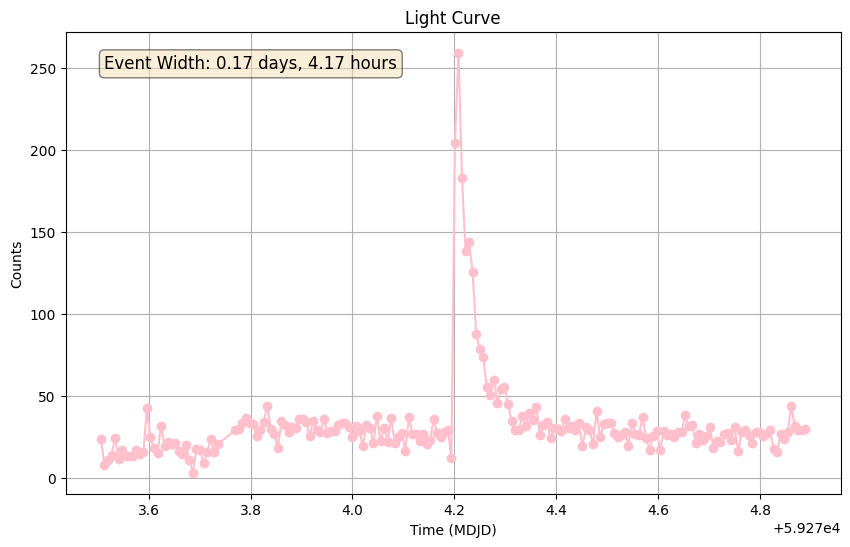

C:\Users\redwy\AppData\Local\Temp\ipykernel_18416\336108666.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coords = SkyCoord(source[1], source[2], unit="deg", frame="icrs")



Determined from lightcurve:
 Object type - mystery
 Transient color - none

Most likely source: 
 Distance = 11.410arcsec 
 Object type = Possible galaxy (more likely star)
 color = red
 Program confidence = 0.150



C:\Users\redwy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\astropy\io\ascii\html.py:91: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  soup = BeautifulSoup("\n".join(lines))
c:\Users\redwy\OneDrive\Documents\skool\Summer\Transient_Classifier_Project\external_photometry.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sm['star'].loc[sm['class_star'

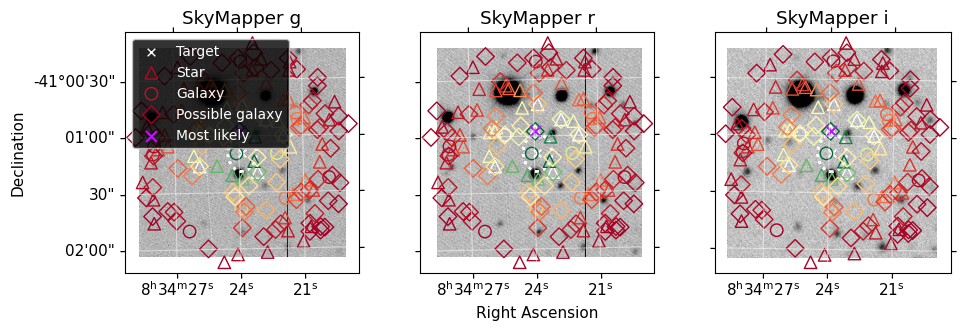

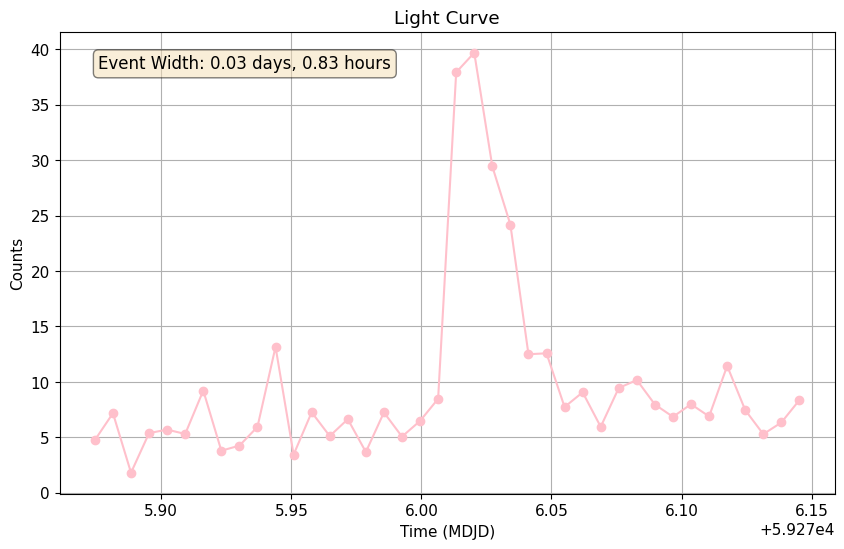

C:\Users\redwy\AppData\Local\Temp\ipykernel_18416\336108666.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coords = SkyCoord(source[1], source[2], unit="deg", frame="icrs")
C:\Users\redwy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\astropy\io\ascii\html.py:91: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  soup = BeautifulSoup("\n".join(lines))
c

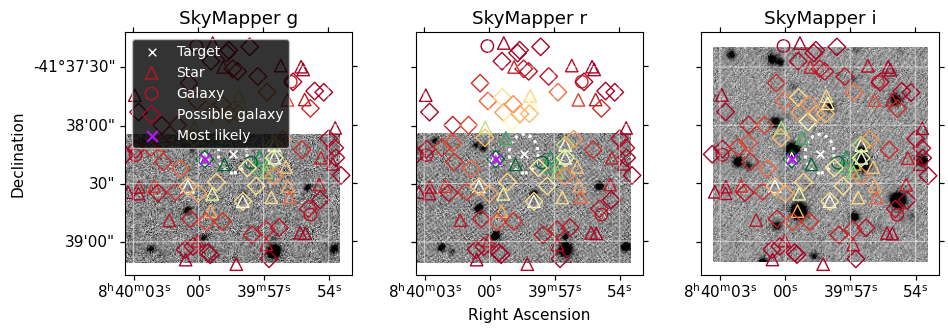

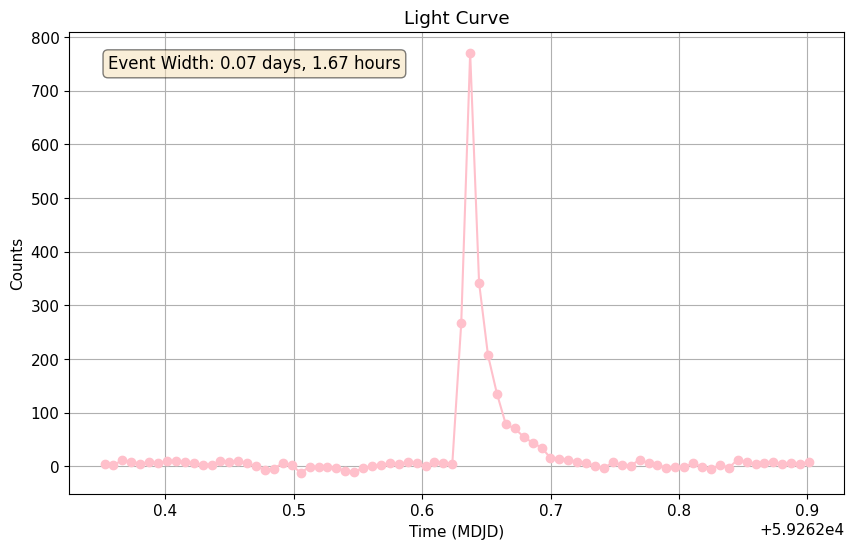

C:\Users\redwy\AppData\Local\Temp\ipykernel_18416\336108666.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coords = SkyCoord(source[1], source[2], unit="deg", frame="icrs")
C:\Users\redwy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\astropy\io\ascii\html.py:91: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  soup = BeautifulSoup("\n".join(lines))
c

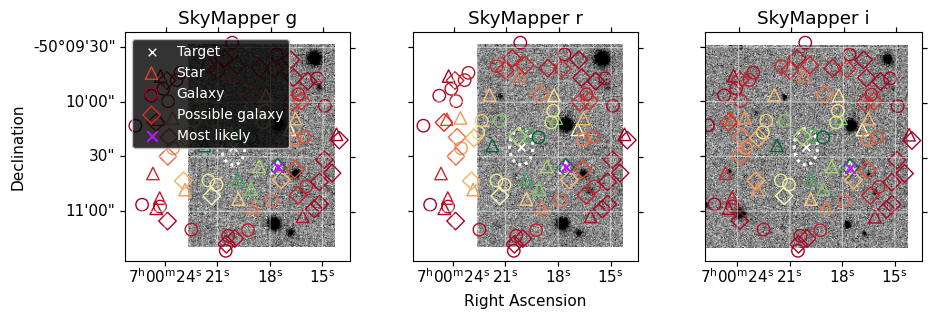

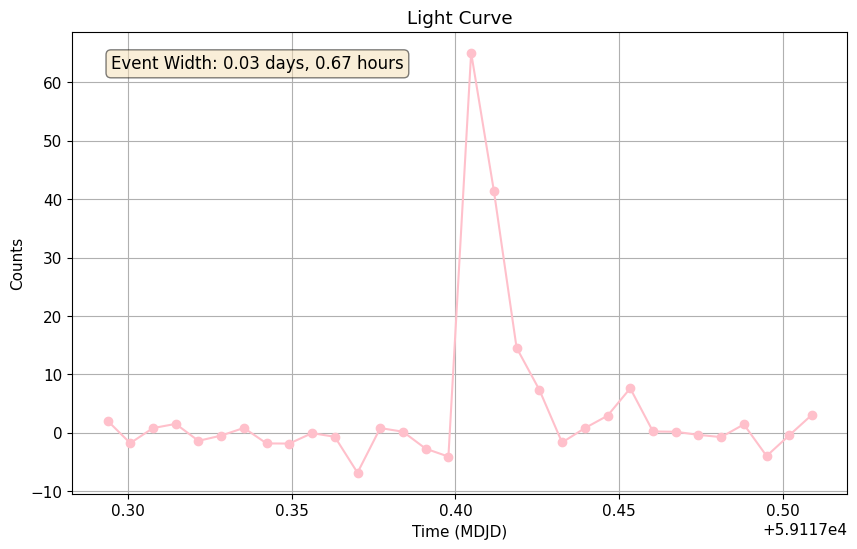

C:\Users\redwy\AppData\Local\Temp\ipykernel_18416\336108666.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coords = SkyCoord(source[1], source[2], unit="deg", frame="icrs")
c:\Users\redwy\OneDrive\Documents\skool\Summer\Transient_Classifier_Project\external_photometry.py:303: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(coords[0],coords[1], transform=ax.get_transform('fk5'),
c:\Users\redwy\OneDrive\Documents\skool\Summer\Transient_Classifier_Project\human_component.py:56: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change

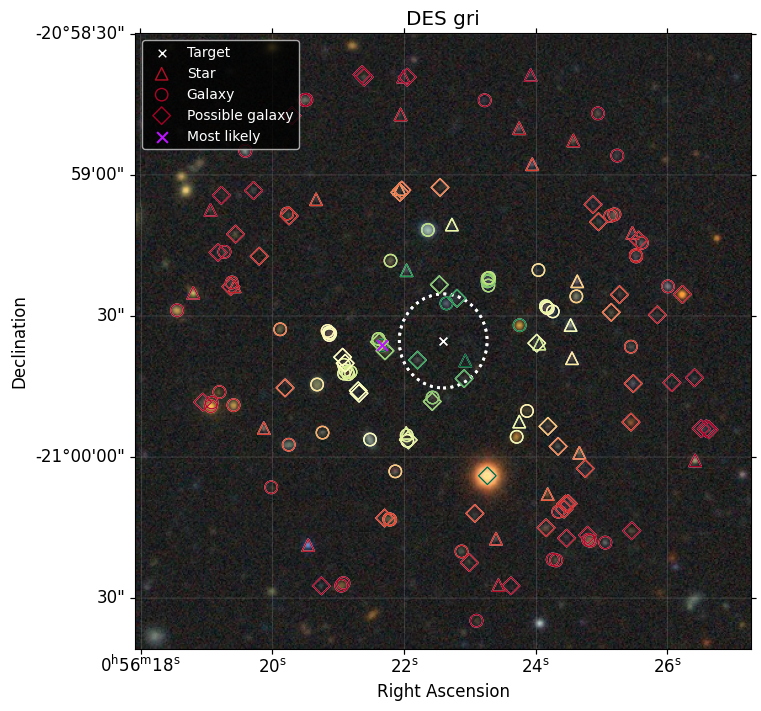

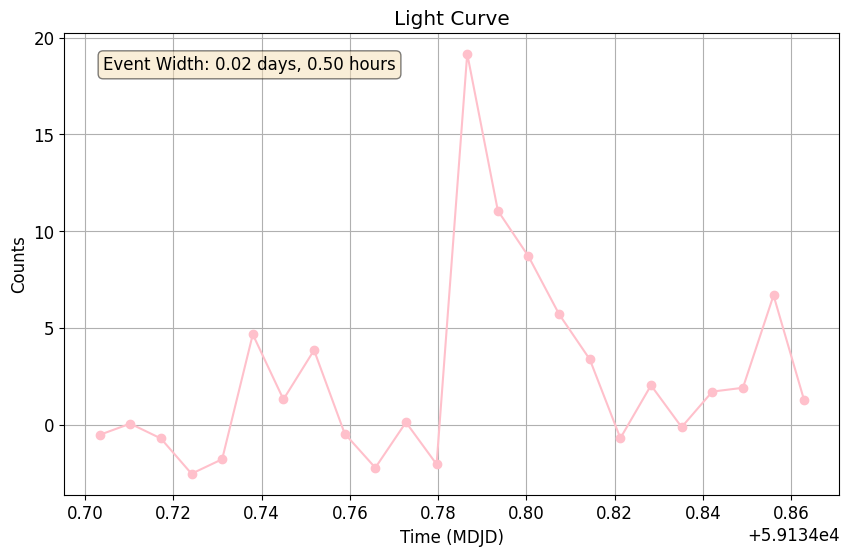

C:\Users\redwy\AppData\Local\Temp\ipykernel_18416\336108666.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coords = SkyCoord(source[1], source[2], unit="deg", frame="icrs")
c:\Users\redwy\OneDrive\Documents\skool\Summer\Transient_Classifier_Project\external_photometry.py:303: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(coords[0],coords[1], transform=ax.get_transform('fk5'),
c:\Users\redwy\OneDrive\Documents\skool\Summer\Transient_Classifier_Project\human_component.py:56: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change

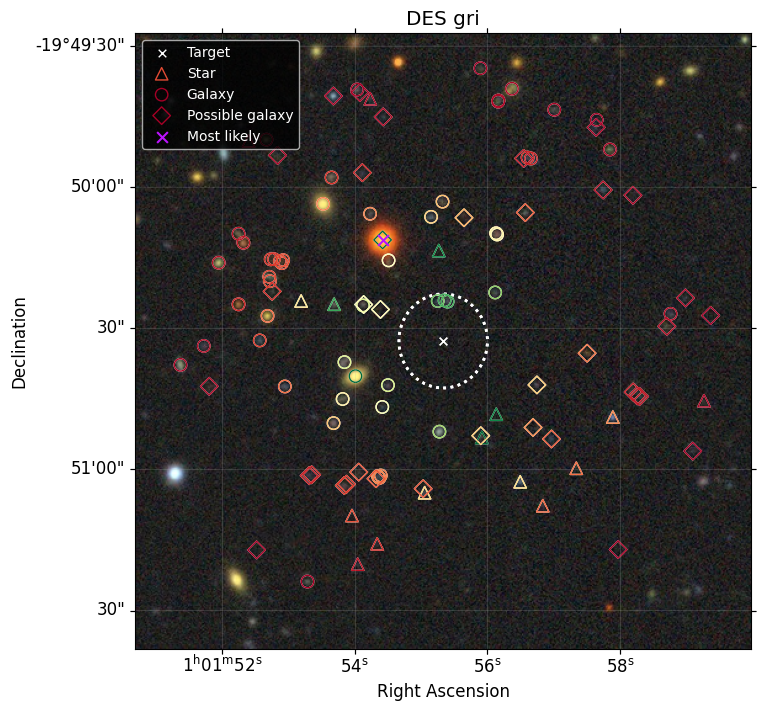

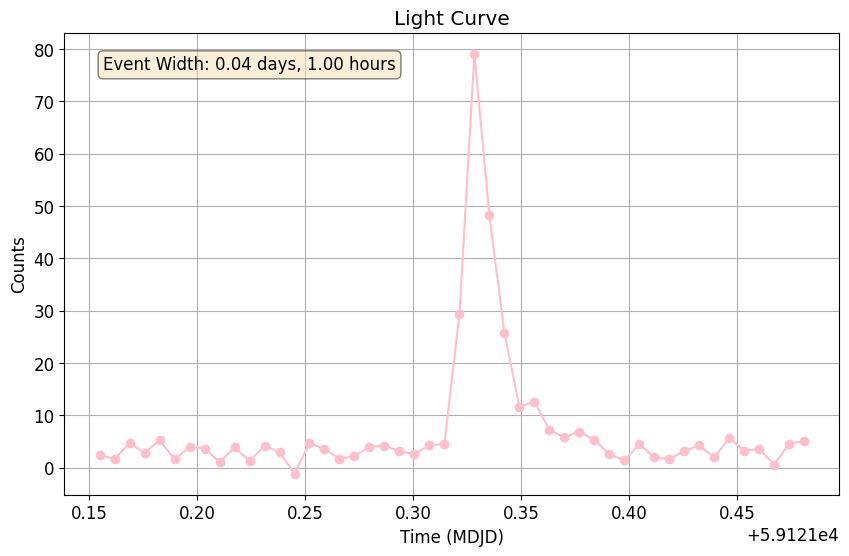

C:\Users\redwy\AppData\Local\Temp\ipykernel_18416\336108666.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coords = SkyCoord(source[1], source[2], unit="deg", frame="icrs")
c:\Users\redwy\OneDrive\Documents\skool\Summer\Transient_Classifier_Project\external_photometry.py:303: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(coords[0],coords[1], transform=ax.get_transform('fk5'),
c:\Users\redwy\OneDrive\Documents\skool\Summer\Transient_Classifier_Project\human_component.py:56: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change

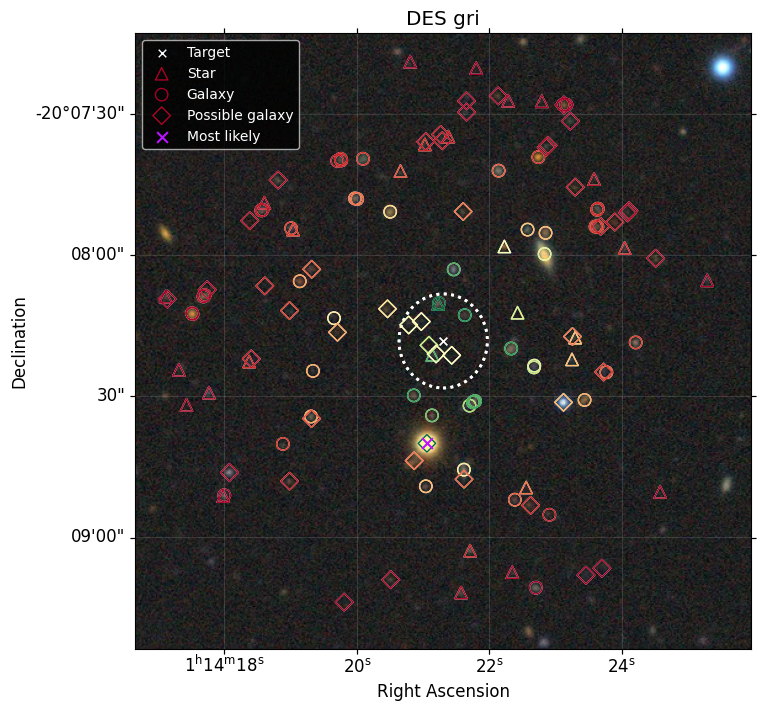

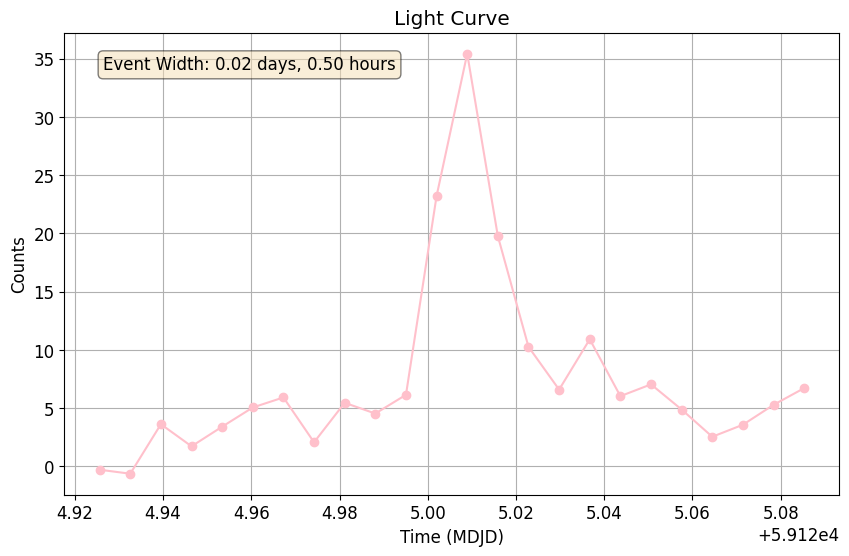

C:\Users\redwy\AppData\Local\Temp\ipykernel_18416\336108666.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coords = SkyCoord(source[1], source[2], unit="deg", frame="icrs")
c:\Users\redwy\OneDrive\Documents\skool\Summer\Transient_Classifier_Project\external_photometry.py:303: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(coords[0],coords[1], transform=ax.get_transform('fk5'),
c:\Users\redwy\OneDrive\Documents\skool\Summer\Transient_Classifier_Project\human_component.py:56: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change

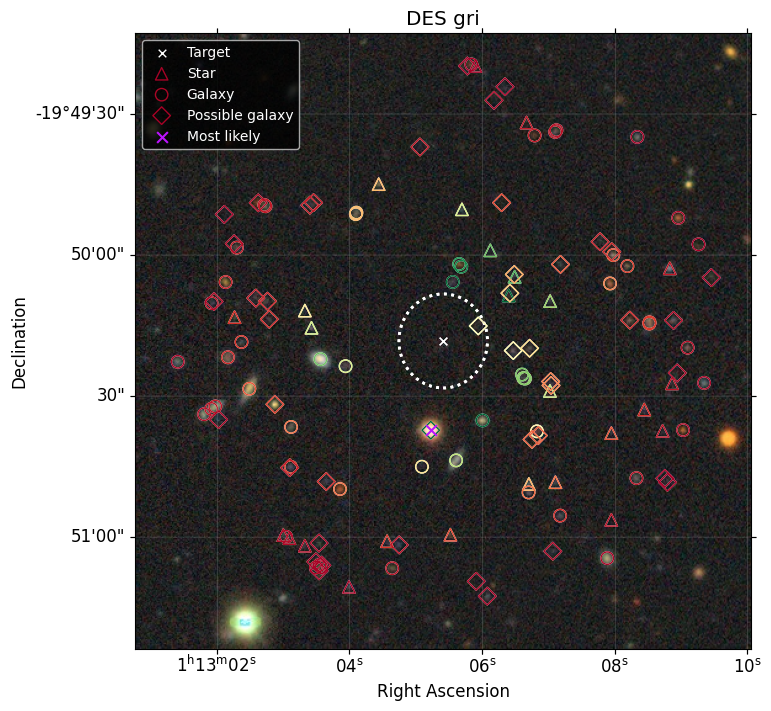

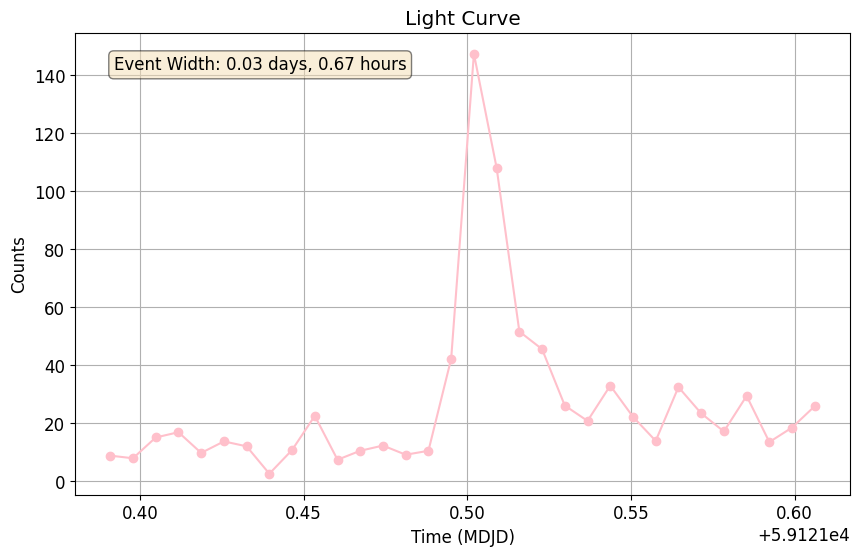

C:\Users\redwy\AppData\Local\Temp\ipykernel_18416\336108666.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coords = SkyCoord(source[1], source[2], unit="deg", frame="icrs")
c:\Users\redwy\OneDrive\Documents\skool\Summer\Transient_Classifier_Project\external_photometry.py:303: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(coords[0],coords[1], transform=ax.get_transform('fk5'),
c:\Users\redwy\OneDrive\Documents\skool\Summer\Transient_Classifier_Project\human_component.py:56: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change

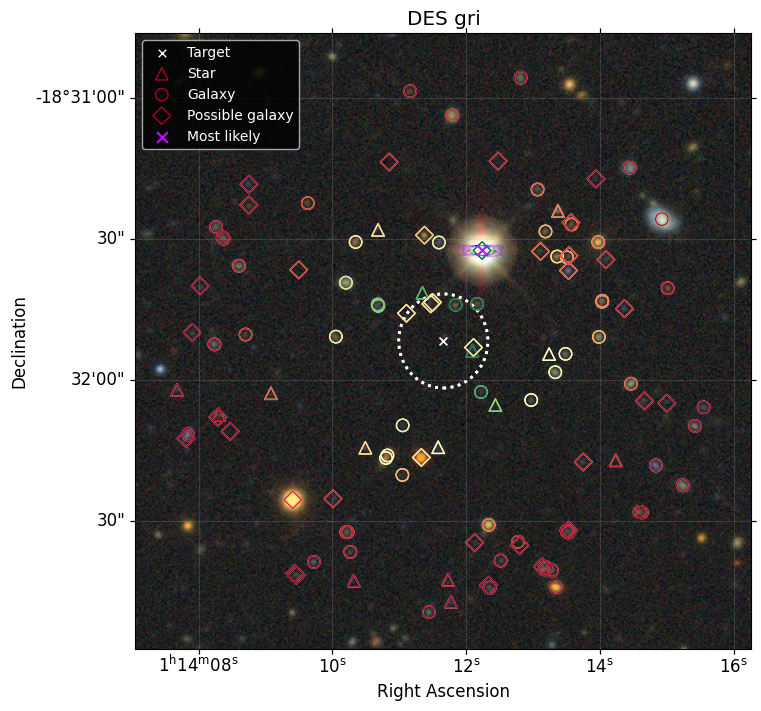

SystemExit: 

C:\Users\redwy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [9]:
def testcase_extractinator():
    "extractinates testcases"
    # Open the csv file for all_uploaded.csv
    all_uploaded = pd.read_csv("all_uploaded.csv")

    # Get the columns called "fig_names", "ra" and "dec" as lists
    fig_names = all_uploaded["fig_names"].tolist()
    ra = all_uploaded["ra"].tolist()
    dec = all_uploaded["dec"].tolist()

    fig_names = [os.path.splitext(fig_name)[0] for fig_name in fig_names]

    # For each fig name in fig_names, check if that fig name is a file which exists in the directory TESS_events
    valid_indices = []
    for i, fig_name in enumerate(fig_names):
        fig_name_csv = fig_name + ".csv"
        if os.path.isfile(os.path.join("TESS_events", fig_name_csv)):
            valid_indices.append(i)

    # Filter the lists to only include valid entries
    fig_names = [fig_names[i] for i in valid_indices]
    ra = [ra[i] for i in valid_indices]
    dec = [dec[i] for i in valid_indices]

    # Load the transient_classifications.csv file
    transient_classifications = pd.read_csv("transient_classifications.csv")

    # Create test cases
    transient_index = 6
    while True:
        print(f"\nExtracting transient {transient_index+1}: {fig_names[transient_index]} ...\n")
        fig_name, ra_val, dec_val = fig_names[transient_index], ra[transient_index], dec[transient_index]
        fig_name_csv = fig_name + ".csv"
        filename = os.path.join("TESS_events", fig_name_csv)
        coords = (ra_val, dec_val)
        testcase = filename, coords
        
        # Check for aggregated_tags in transient_classifications.csv
        aggregated_tags = agg_tags(fig_name, transient_classifications)

        
        transient_index = is_source_transient(testcase, transient_index, aggregated_tags)
        # if transient_index == 9:
        #     raise ValueError("Program finished")
        
testcase_extractinator()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e3a31782-ff01-4116-bf34-fe87fcb8112c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>